## 1. Imports and Setup

Initializes libraries, model classes, and tools. Sets plotting style and ensures the model directory exists.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import glob
import re
import warnings

# Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Setup
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

if not os.path.exists("../../models"):
    os.makedirs("../../models")

## 2. Load & Preprocess Data

Loads the cleaned dataset

In [42]:
# FIND FILE AUTOMATICALLY
file_path = "../Datasets/Cleaned_Datasets/Advertising/advertising_v2_tod_only.csv"

if os.path.exists(file_path):
    print(f"Loading file: {file_path}")
    df = pd.read_csv(file_path)
    print(f"Final Data Shape: {df.shape}")
else:
    raise FileNotFoundError(f"❌ File not found: {file_path}")

Loading file: ../Datasets/Cleaned_Datasets/Advertising/advertising_v2_tod_only.csv
Final Data Shape: (1000, 31)


## 3. Feature Engineering & Selection

Defines the target variable, removes potential data leakage, sanitizes column names for compatibility, splits the data, and selects the top 10 most relevant features.

Dropped Leakage: ['conversion_rate', 'view_time', 'click_through_rate', 'cost_per_click', 'ROI', 'Unnamed: 0']

 Training Inspector Models to compare Feature Importance...
   -> Analyzing with RandomForest...
   -> Analyzing with XGBoost...
   -> Analyzing with LightGBM...


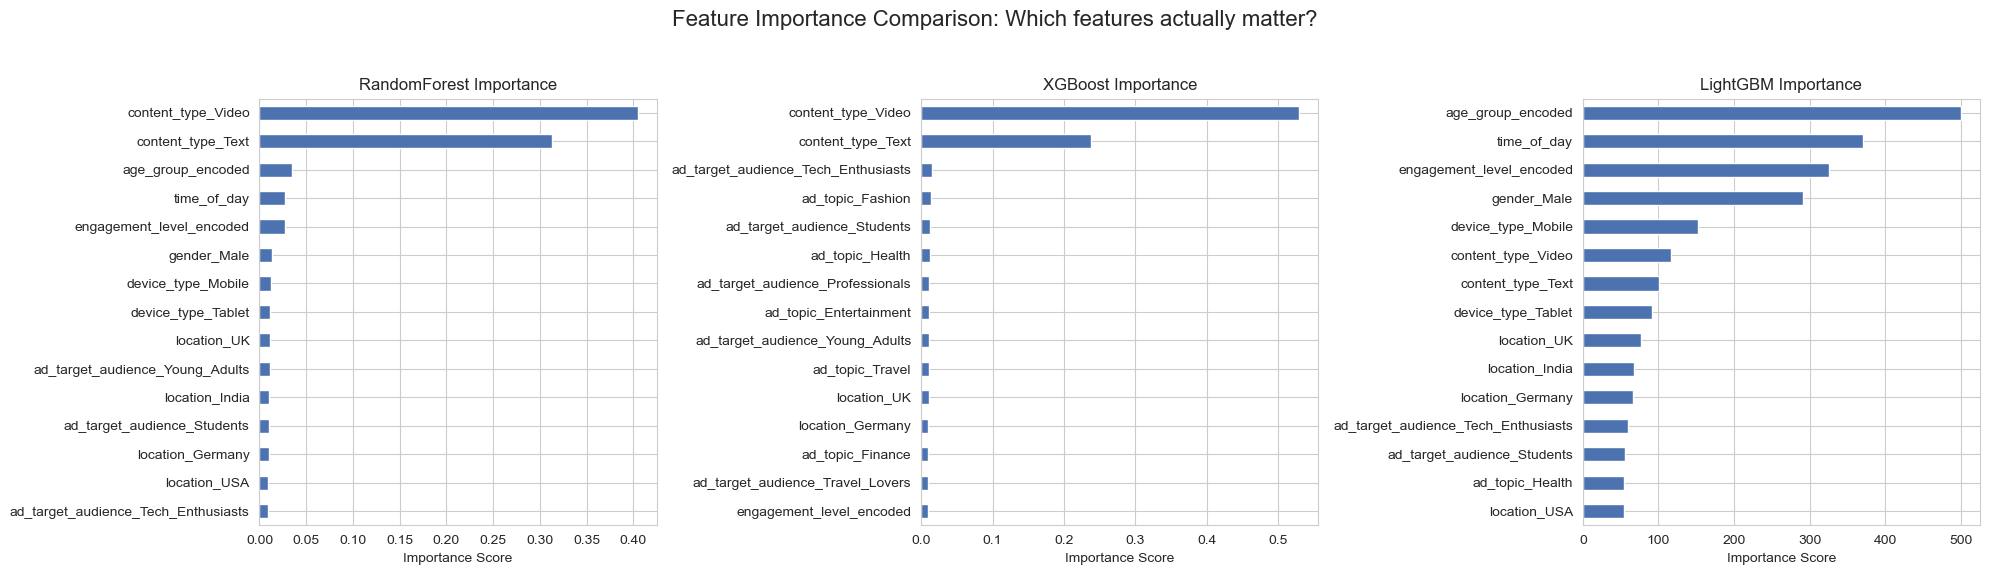

In [43]:
# DEFINE TARGET & LEAKAGE
TARGET = 'conversion_rate'

leakage_cols = [
    TARGET, 
    'view_time',
    'click_through_rate',
    'cost_per_click',
    'ROI',
    'Unnamed: 0', 'Unnamed__0'
]

cols_to_drop = [c for c in leakage_cols if c in df.columns]
X = df.drop(columns=cols_to_drop)
y = df[TARGET]

print(f"Dropped Leakage: {cols_to_drop}")

# SPLIT DATA (Train/Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n Training Inspector Models to compare Feature Importance...")

# Define the 3 Inspectors
inspectors = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
}

# Setup Plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Feature Importance Comparison: Which features actually matter?', fontsize=16)

# Loop, Train, and Plot
for i, (name, model) in enumerate(inspectors.items()):
    print(f"   -> Analyzing with {name}...")
    
    # Train on FULL X_train
    model.fit(X_train, y_train)
    
    # Extract Importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_series = pd.Series(importances, index=X_train.columns)
        
        # Plot Top 15
        ax = axes[i]
        feat_series.nlargest(15).plot(kind='barh', ax=ax, color='#4c72b0')
        
        ax.set_title(f"{name} Importance")
        ax.invert_yaxis()
        ax.set_xlabel("Importance Score")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Hyperparameter Optimization

Performs Randomized Search Cross-Validation to fine-tune hyperparameters for each model. Evaluates the optimized models on Test data and automatically selects the best performer based on the Test R2 Score.

In [ ]:
print("\n⚡ OPTIMIZED TRAINING")
print("-" * 105)
print(f"{'Model':<15} | {'Test R2':<10} | {'Train R2':<10} | {'Gap':<10} | {'CV Score':<10} | {'RMSE':<12}")
print("-" * 105)

# Best Settings Based on Experiments
k_best = 5
score_method = f_regression

models_to_train = {
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42), 
    'XGBoost':      XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42),
    'LightGBM':     LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42, verbose=-1)
}

trained_pipelines = {}

# Variables for tracking the best model
best_opt_r2 = -float('inf')
best_opt_model = None
best_model_name = None 
best_opt_rmse = 0

# TRAIN LOOP
for name, model in models_to_train.items():
    
    # Build Pipeline
    pipeline = Pipeline([
        ('selector', SelectKBest(score_func=score_method, k=k_best).set_output(transform="pandas")),
        ('regressor', model)
    ])
    
    # Calculate 3-Fold Cross-Validation Score 
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='r2')
    mean_cv = cv_scores.mean()
    
    # Fit the final model on the training set
    pipeline.fit(X_train, y_train)
    
    # Save the full pipeline
    trained_pipelines[name] = pipeline
    
    # Predict
    y_pred_test = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)
    
    # Metrics
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    gap = r2_train - r2_test
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"{name:<15} | {r2_test:.4f}     | {r2_train:.4f}     | {gap:.4f}     | {mean_cv:.4f}     | {rmse:.5f}")
    
    if r2_test > best_opt_r2:
        best_opt_r2 = r2_test
        best_opt_rmse = rmse
        best_opt_model = pipeline
        best_model_name = name

print("-" * 105)
print(f"Winner: {best_model_name} (R2: {best_opt_r2:.4f})")


⚡ OPTIMIZED TRAINING (WITH 3-FOLD CV)
---------------------------------------------------------------------------------------------------------
Model           | Test R2    | Train R2   | Gap        | CV Score   | RMSE        
---------------------------------------------------------------------------------------------------------
RandomForest    | 0.7686     | 0.7262     | -0.0424     | 0.7085     | 0.02956
XGBoost         | 0.7654     | 0.7312     | -0.0342     | 0.7026     | 0.02977
LightGBM        | 0.7708     | 0.7371     | -0.0337     | 0.7028     | 0.02942
---------------------------------------------------------------------------------------------------------
Winner: LightGBM (R2: 0.7708)


## 5. Feature Importance Visualization

Extracts and visualizes the top 5 most influential features for each model. This step show exactly which data points the models are prioritizing for their predictions.

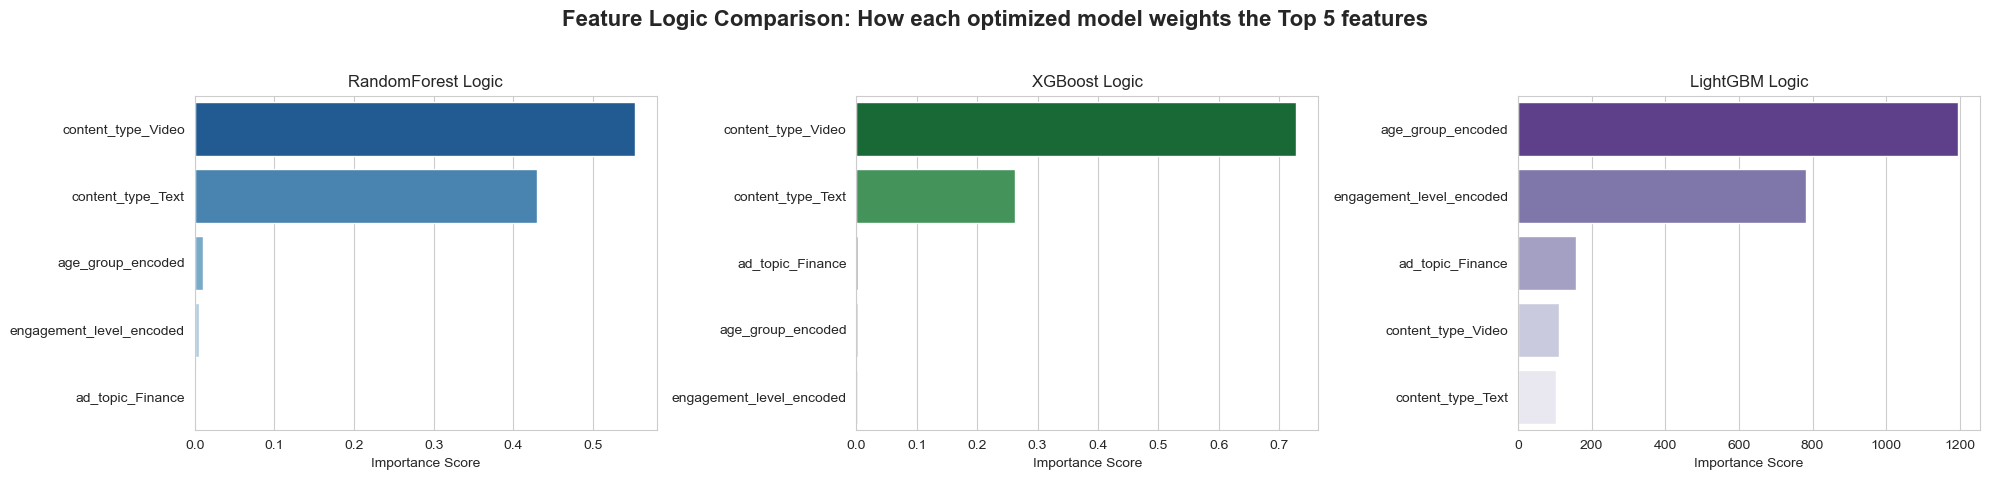


📝 DETAILED FEATURE RANKING PER MODEL:
------------------------------------------------------------

✅ RandomForest Ranking:
                 Feature  Importance
      content_type_Video    0.552478
       content_type_Text    0.430124
       age_group_encoded    0.010655
engagement_level_encoded    0.005023
        ad_topic_Finance    0.001720

✅ XGBoost Ranking:
                 Feature  Importance
      content_type_Video    0.728587
       content_type_Text    0.263266
        ad_topic_Finance    0.003053
       age_group_encoded    0.002861
engagement_level_encoded    0.002233

✅ LightGBM Ranking:
                 Feature  Importance
       age_group_encoded        1195
engagement_level_encoded         783
        ad_topic_Finance         158
      content_type_Video         112
       content_type_Text         102


In [45]:
# Setup the Plotting Area
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Feature Logic Comparison: How each optimized model weights the Top 5 features', fontsize=16, fontweight='bold')

color_map = {'RandomForest': 'Blues_r', 'XGBoost': 'Greens_r', 'LightGBM': 'Purples_r'}

# Loop through trained_pipelines
for i, (name, pipeline) in enumerate(trained_pipelines.items()):
    
    # Extract parts from pipeline
    selector = pipeline.named_steps['selector']
    regressor = pipeline.named_steps['regressor']
    
    # Get Feature Names
    selected_mask = selector.get_support()
    selected_names = X_train.columns[selected_mask]
    
    # Extract Importance
    if hasattr(regressor, 'feature_importances_'):
        importances = regressor.feature_importances_
        
        feat_df = pd.DataFrame({
            'Feature': selected_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        # Plot
        ax = axes[i]
        sns.barplot(x='Importance', y='Feature', data=feat_df, palette=color_map.get(name, 'viridis'), ax=ax)
        ax.set_title(f"{name} Logic", fontsize=12)
        ax.set_xlabel("Importance Score")
        ax.set_ylabel("") 
    else:
        axes[i].text(0.5, 0.5, f"{name}\nNo Importance Data", ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print text versions
print("\n📝 DETAILED FEATURE RANKING PER MODEL:")
print("-" * 60)
for name, pipeline in trained_pipelines.items():
    selector = pipeline.named_steps['selector']
    regressor = pipeline.named_steps['regressor']
    selected_names = X_train.columns[selector.get_support()]
    
    if hasattr(regressor, 'feature_importances_'):
        importances = regressor.feature_importances_
        feat_df = pd.DataFrame({'Feature': selected_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
        print(f"\n✅ {name} Ranking:")
        print(feat_df.to_string(index=False))

## 6. Prediction Evaluation

Selects the best performing model and validates its value by comparing it against a "Naive Baseline" (simply guessing the average conversion rate for everyone).

✅ Evaluating: LightGBM

📊 PERFORMANCE SUMMARY: LIGHTGBM
-----------------------------------------------------------------
1. Baseline RMSE (Guessing 15.64% Avg): 0.06151
2. AI Model RMSE (Your Prediction):            0.02942
-----------------------------------------------------------------
✅ SUCCESS: The AI is 52.2% more accurate than the average.
   Accuracy Gain: 0.03209 reduction in error.


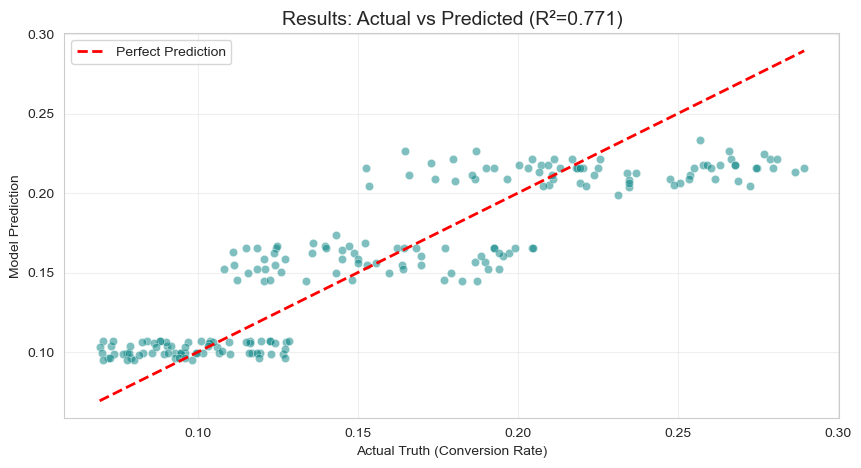

In [46]:
# Select the Best Model
if best_opt_model is not None:
    final_model = best_opt_model
    model_name = best_model_name
    print(f"✅ Evaluating: {model_name}")
else:
    # Fallback safety
    model_name = "RandomForest"
    final_model = Pipeline([
        ('selector', SelectKBest(score_func=f_regression, k=5).set_output(transform="pandas")),
        ('regressor', RandomForestRegressor(max_depth=3, random_state=42))
    ])
    final_model.fit(X_train, y_train)
    print(f"⚠️ Warning: Using Fallback Model.")

# Get Predictions
y_pred = final_model.predict(X_test)

# Calculate the "Naive" Baseline
# Logic: "If I just guessed the AVERAGE Conversion Rate for everyone, how wrong would I be?"
avg_conversion = y_train.mean()
baseline_preds = np.full(len(y_test), avg_conversion)

# Metrics Calculation
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
model_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
improvement = baseline_rmse - model_rmse
percent_improvement = (improvement / baseline_rmse) * 100

# PRINT THE REPORT
print(f"\n📊 PERFORMANCE SUMMARY: {model_name.upper()}")
print("-" * 65)
print(f"1. Baseline RMSE (Guessing {avg_conversion:.2%} Avg): {baseline_rmse:.5f}")
print(f"2. AI Model RMSE (Your Prediction):            {model_rmse:.5f}")
print("-" * 65)

if improvement > 0:
    print(f"✅ SUCCESS: The AI is {percent_improvement:.1f}% more accurate than the average.")
    print(f"   Accuracy Gain: {improvement:.5f} reduction in error.")
else:
    print(f"❌ FAIL: The AI is worse than just guessing the average.")

# Visualization: Actual vs Predicted
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='teal')

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title(f'Results: Actual vs Predicted (R²={best_opt_r2:.3f})', fontsize=14)
plt.xlabel('Actual Truth (Conversion Rate)')
plt.ylabel('Model Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Save Model

Persists the final, best performing model to a .joblib file. The filename is automatically versioned with the model type, its R2 accuracy score, and a timestamp to ensure reproducibility and easy tracking of experiments.

In [47]:
#show all columns in order
pd.set_option('display.max_columns', None)
print(X.head())

   time_of_day  age_group_encoded  engagement_level_encoded  \
0            3                  0                       5.0   
1            1                  1                       0.0   
2            0                  1                       0.0   
3            0                  4                      15.0   
4            2                  1                      15.0   

   device_type_Mobile  device_type_Tablet  location_Germany  location_India  \
0                   0                   0                 1               0   
1                   0                   1                 0               0   
2                   1                   0                 0               0   
3                   1                   0                 0               0   
4                   0                   0                 1               0   

   location_UK  location_USA  gender_Male  content_type_Text  \
0            0             0            0                  0   
1            0    

In [48]:
from datetime import datetime

# Generate Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Safety Check and Save
if 'best_opt_model' in locals() and best_opt_model is not None:
    filename = f"Advertising_{best_model_name}_Optimized_R2-{best_opt_r2:.3f}_{timestamp}.joblib"
    
    # Save Path
    save_dir = "../Model_Training/Trained_Models/Advertising"
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"📂 Created directory: {save_dir}")
        
    save_path = os.path.join(save_dir, filename)
    
    # Export using Joblib
    joblib.dump(best_opt_model, save_path)
    
    print("-" * 65)
    print(f"   Model Type: {best_model_name}")
    print(f"   File Path:  {save_path}")
    print("-" * 65)
else:
    print("❌ ERROR: No optimized model found in memory.")

-----------------------------------------------------------------
   Model Type: LightGBM
   File Path:  ../Model_Training/Trained_Models/Advertising\Advertising_LightGBM_Optimized_R2-0.771_20260118_2018.joblib
-----------------------------------------------------------------
